# Support Vector Machine Pixelwise Classifier

In [1]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# %load ../../../data_preprocessing/functions.py
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# A function to plot a matrix
def plot_image(data, colorspace='binary'):
    fig = plt.figure(figsize=(10,10)) 
    ax = fig.add_subplot(111)
    ax.imshow(data, cmap=colorspace)
    
    
def normalize_array(array):
    array_min = array.min(axis=(0, 1), keepdims=True)
    array_max = array.max(axis=(0, 1), keepdims=True)
    normalized_array = (array - array_min)/(array_max - array_min)
    
    return normalized_array

def normalize_with_preset(array, max_value, min_value):
    normalized_array = (array - min_value)/(max_value - min_value)
    
    return normalized_array


def recreate_image(labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    image = np.zeros((w, h))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = labels[label_idx]
            label_idx += 1
    return image

def overlay_images(image1, image2, colorspace1='binary', colorspace2='magma', transparency=0.5):
    plt.imshow(image1, cmap=colorspace1, interpolation='nearest')
    plt.imshow(image2, cmap=colorspace2, alpha=transparency, interpolation='bilinear')
    plt.show()
    
def flatten_normalize_neighbors(training_set, global_max=233, global_min=69):
    flattened_neighbors = []
    neighbors = training_set['neighbors']

    for i in range(len(neighbors)):
        numpy_array = np.array(neighbors[i]).reshape(-1, 1)
        normalized_neighbors = normalize_with_preset(numpy_array, global_max, global_min)
        flattened_neighbors.append(normalized_neighbors)
    
    return np.array(flattened_neighbors).reshape((len(flattened_neighbors), -1))

def extract_values_from_training_data_locations(training_data, image_channel):
    data_values = []
    
    for row in training_data:
        data_values.append(np.array([(image_channel[row[0], row[1]]), row[2]]))
        
    data_values = np.array(data_values)
    
    return data_values

def extract_neighborhood_values_from_training_data_locations(training_data, image_channel):
    data_values = []
    
    for row in training_data:
        data_values.append(np.array([(image_channel[row[0], row[1]]), row[2]]))
        
    data_values = np.array(data_values)
    
    return data_values

def flatten_neighbors(neighbors):
    data_values = []
    
    for neighbor in neighbors:
        #data_values.append(neighbor[0].reshape(-1, 1))
        data_values.append(neighbor[0])
    
    data_values = np.array(data_values)
    
    return data_values

## Open up the files that contain the labels

In [3]:
training_set_values = np.load("../data/june10/training_data_values.npy")
training_set_labels = np.load("../data/june10/training_data_labels.npy")

In [7]:
pd.DataFrame(training_set_labels)

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [6]:
pd.DataFrame(training_set_values)

,0,1,2,3,4,5
0,0.823529,0.776471,0.720472,0.100806,0.148649,0.823529
1,0.886275,0.858824,0.791339,0.129032,0.117117,0.886275
2,0.937255,0.913725,0.854331,0.120968,0.108108,0.941176
3,0.968627,0.960784,0.925197,0.149194,0.049550,0.968627
4,0.956863,0.952941,0.913386,0.169355,0.058559,0.956863
5,0.937255,0.925490,0.881890,0.161290,0.067568,0.937255
6,0.956863,0.952941,0.913386,0.169355,0.054054,0.960784
7,0.941176,0.937255,0.893701,0.161290,0.067568,0.945098
8,0.945098,0.941176,0.897638,0.169355,0.067568,0.949020
9,0.917647,0.921569,0.862205,0.169355,0.072072,0.925490


In [4]:
values_train, values_test, labels_train, labels_test = train_test_split(training_set_values, training_set_labels, test_size=0.10, random_state=0)

In [8]:
labels_test

array([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.])

## Initialize the SVM algorithm

In [9]:
classifier = svm.SVC()

In [10]:
classifier.fit(values_train, labels_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Load up the orthomosaic

In [11]:
image_data = np.load("../../../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_rgb.npy")[0:6000, 0:6000, :]
hsv_data = np.load("../../../../data_preprocessing/data_preprocessing/numpy_data/indios_b/normalized_filtered_hsv.npy")[0:6000, 0:6000, :]

In [12]:
image_data.shape

(6000, 6000, 3)

In [13]:
multidimensional_ortho = np.dstack((image_data, hsv_data))

In [14]:
w, h, c = tuple(multidimensional_ortho.shape)

In [15]:
image_data.shape

(6000, 6000, 3)

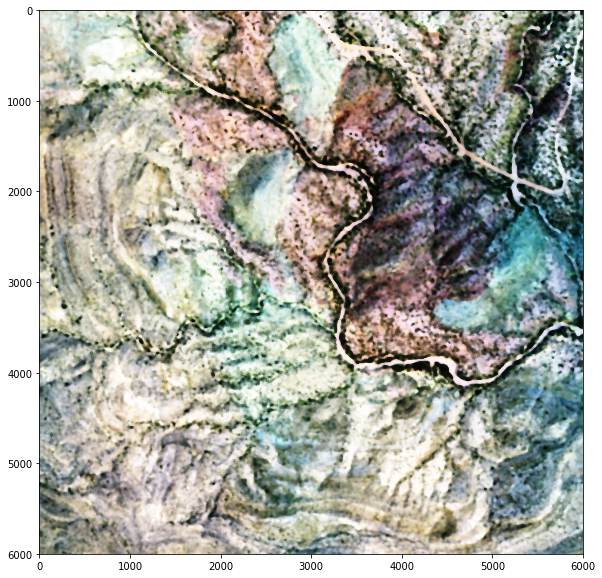

In [16]:
plot_image(image_data)

In [28]:
normalized_image = normalize_array(image_data)

In [46]:
from sklearn.utils import shuffle
A = shuffle(normalized_image[:, :, 0], random_state=1)
B = shuffle(normalized_image[:, :, 1], random_state=20)
C = shuffle(normalized_image[:, :, 2], random_state=300)

In [47]:
howdy = np.dstack((A, B, C))

In [48]:
howdy.shape

(6000, 6000, 3)

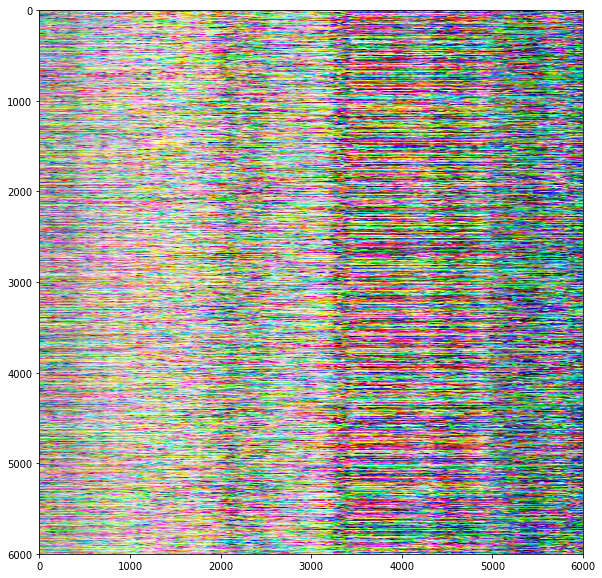

In [49]:
plot_image(howdy)

In [12]:
reshaped_ortho = multidimensional_ortho.reshape(w*h, -1, c)

In [13]:
predicted_image = np.zeros((w, h))

In [1]:
clabels = classifier.predict(reshaped_ortho.reshape(-1, c))

NameError: name 'classifier' is not defined

In [24]:
t0 = time()
labeled_image = recreate_image(labels, w, h)
print("done in %0.3fs." % (time() - t0))

done in 10.923s.


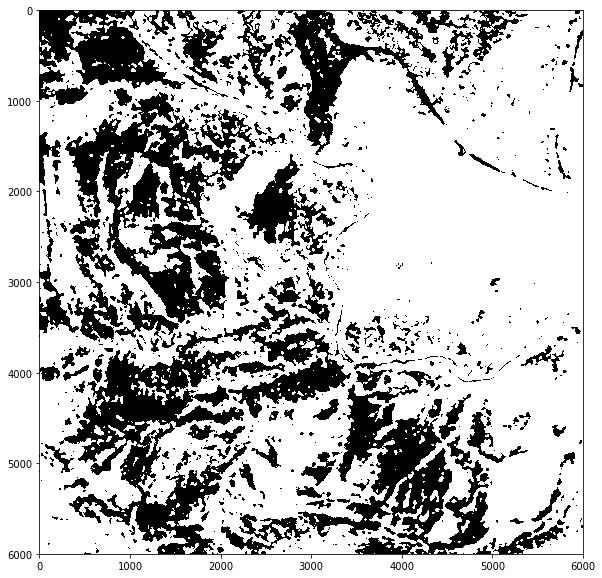

In [25]:
plot_image(labeled_image)

In [26]:
from skimage.filters.rank import median
from skimage.morphology import disk, binary_dilation, closing, binary_erosion, binary_opening

In [28]:
dil = binary_dilation(labeled_image, selem=disk(5))

In [29]:
ope = binary_opening(dil, selem=disk(4))

In [30]:
med = median(dil, disk(10))

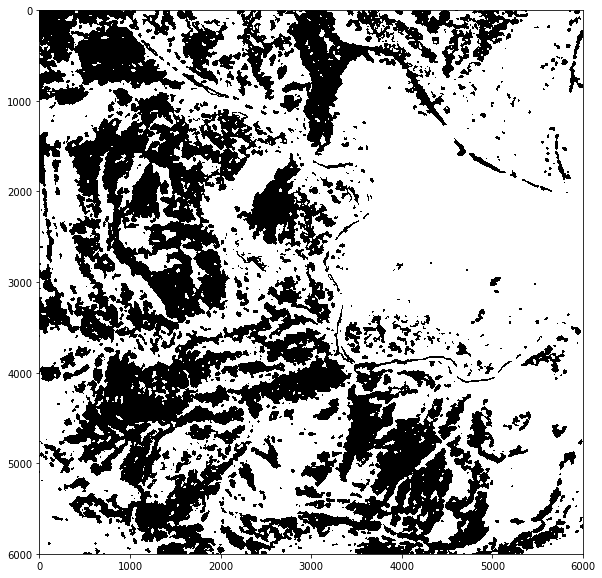

In [32]:
plot_image(ope)

### Classification report

In [12]:
from sklearn.metrics import classification_report
from sklearn.externals import joblib
# clf = joblib.load('./knn_trained_with_hsv_only_b.pkl')

predicted_test_labels = classifier.predict(values_test)

target_names = ["Bluff Mesa Formation", "Lower Yucca"]
print(classification_report(labels_test, predicted_test_labels, target_names=target_names))

                      precision    recall  f1-score   support

Bluff Mesa Formation       0.74      0.82      0.78        61
         Lower Yucca       0.61      0.49      0.54        35

         avg / total       0.69      0.70      0.69        96



In [19]:
classifier.score(values_test, labels_test)

0.6979166666666666